# Import Libs

In [ ]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import * 
import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not shutil.which("ipopt"):
    # here is the IPOPT zip file
    !gdown 10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
    !unzip -o -q ipopt-linux64_dw
    assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

SOLVER = 'ipopt'
EXECUTABLE = '/content/ipopt'
ipopt_executable = '/content/ipopt'

# some stock-specific packages
!pip install yahoo_fin
!pip install requests_html
import yahoo_fin.stock_info as si

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.2 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
To: /content/ipopt-linux64_dw.zip
100% 1.82M/1.82M [00:00<00:00, 77.3MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.6 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1270 sha256=4ff530428b3d4a71564b6c6b61b18fe8aff2f2a38d7248435f0144e3e

# 1 - Data Preparation and EDA


Consumer discretionary - Amazon (AMZN), Nike(TSL), Starbucks(SBUX)

Industrial - FedEx Corporation(FDX), The Boeing Company(BA), United Parcel Service(UPS)

Technology - Apple Inc(AAPL), Microsoft Corporation(MSFT), QUALCOMM Incorporated(QCOM)

In [ ]:
# Assign the ticker list that we want to 
tickers_list = ['AMZN','NKE','SBUX','FDX','BA','UPS','AAPL','MSFT','QCOM']
# pull historical price data for each stocks to match with our news score later
dow_prices = {ticker : si.get_data(ticker,start_date = '01/01/2017',end_date='12/31/2021',interval='1d') for ticker in tickers_list}

In [ ]:
#display
dow_prices

{'AMZN':                   open        high         low       close    adjclose  \
 2017-01-03   37.896000   37.938000   37.384998   37.683498   37.683498   
 2017-01-04   37.919498   37.984001   37.709999   37.859001   37.859001   
 2017-01-05   38.077499   39.119999   38.013000   39.022499   39.022499   
 2017-01-06   39.118000   39.972000   38.924000   39.799500   39.799500   
 2017-01-09   39.900002   40.088501   39.588501   39.846001   39.846001   
 ...                ...         ...         ...         ...         ...   
 2021-12-23  170.427994  171.975006  170.149994  171.068497  171.068497   
 2021-12-27  171.037003  172.942993  169.215500  169.669495  169.669495   
 2021-12-28  170.182495  172.175995  169.135498  170.660995  170.660995   
 2021-12-29  170.839996  171.212006  168.600494  169.201004  169.201004   
 2021-12-30  169.699997  170.888000  168.524002  168.644501  168.644501   
 
                volume ticker  
 2017-01-03   70422000   AMZN  
 2017-01-04   50210000   A

## 1.1 Data Retrieval and Cleaning

In [ ]:
# let's extract just the data we need (adjclose)
# get the adjclose price for the NFLX (one sample)
prep_data = pd.DataFrame(dow_prices['AMZN']['adjclose']).rename(columns = {"adjclose":"AMZN"})

# combine all the tickers (all the rest of the samples)
for i in tickers_list[1:]:
  prep_data[i] = pd.DataFrame(dow_prices[i]['adjclose'])
prep_data

,AMZN,NKE,SBUX,FDX,BA,UPS,AAPL,MSFT,QCOM
2017-01-03,37.683498,48.682549,48.835850,172.037262,145.533676,94.947662,27.133329,57.501343,54.375095
2017-01-04,37.859001,49.703396,49.400524,172.963043,147.063492,94.972427,27.102961,57.244068,54.433308
2017-01-05,39.022499,49.694046,49.815216,172.688095,147.146881,95.021935,27.240786,57.244068,54.499813
2017-01-06,39.799500,50.490128,50.406361,174.374542,147.508484,95.211685,27.544476,57.740246,54.483181
2017-01-09,39.846001,49.993736,51.350433,173.861252,146.785339,94.691895,27.796766,57.556484,54.582954
...,...,...,...,...,...,...,...,...,...
2021-12-23,171.068497,163.442932,109.214119,247.261414,204.220001,203.599411,174.995621,330.754578,177.791214
2021-12-27,169.669495,165.327225,111.012169,249.628616,203.169998,206.401184,179.016129,338.423340,181.283981
2021-12-28,170.660995,164.182831,112.324234,249.813705,206.130005,205.988586,177.983673,337.237457,179.814911
2021-12-29,169.201004,166.511124,113.111481,250.836563,203.660004,205.911819,178.073044,337.929260,181.157501


In [ ]:
#Number of rows and columns
prep_data.shape

(1258, 9)

In [ ]:
# drop the na records
#prep_data.dropna(inplace=True)
for i in tickers_list:
  prep_data[i] = prep_data[i].pct_change()
# drop the na records
prep_data.dropna(inplace=True)

In [ ]:
prep_data.shape

(1257, 9)

In [ ]:
con_df = prep_data[['AMZN','NKE','SBUX']].copy()

ind_df = prep_data[['FDX','BA','UPS']].copy()

tech_df = prep_data[['AAPL','MSFT','QCOM']].copy()

## 1.2 Time Series Visualizations






### 1.2.1 Visualization of Consumer Discretionary Sector 

<Axes: >

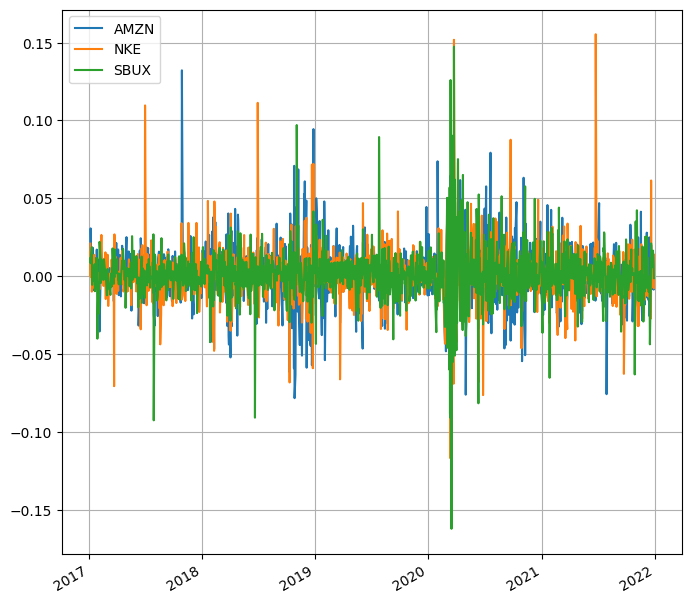

In [ ]:
con_df.plot(grid=True, 
        layout=(3,4),
         figsize=(8,8))

### 1.2.2 Visualization of Industrials Sector 

<Axes: >

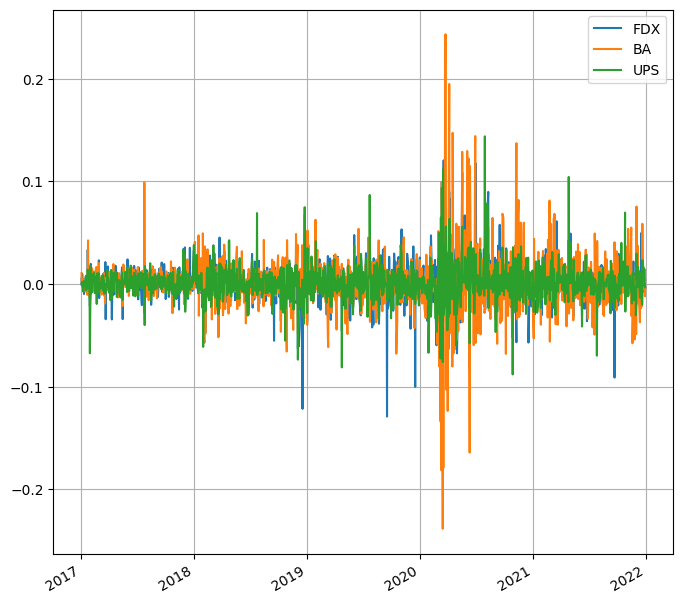

In [ ]:
ind_df.plot(grid=True, 
        layout=(3,4),
         figsize=(8,8))


### 1.2.3 Visualization of Technology Sector

<Axes: >

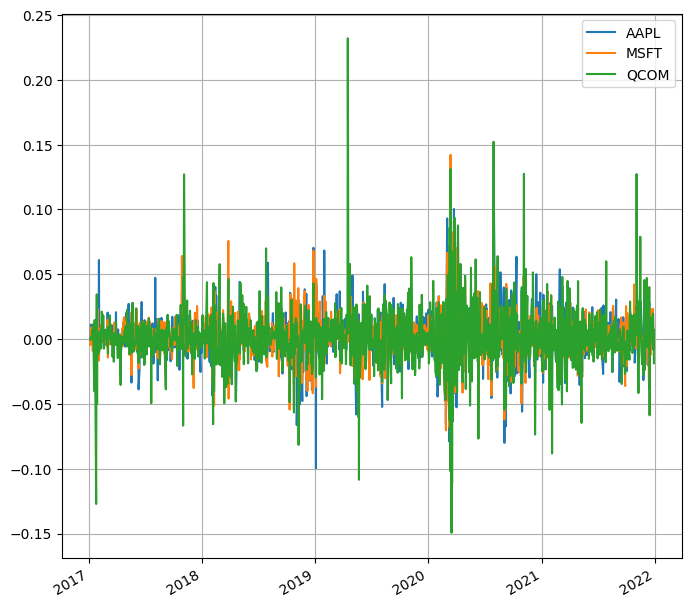

In [ ]:
tech_df.plot(grid=True, 
        layout=(3,4),
         figsize=(8,8))

### Visualisation of all 9


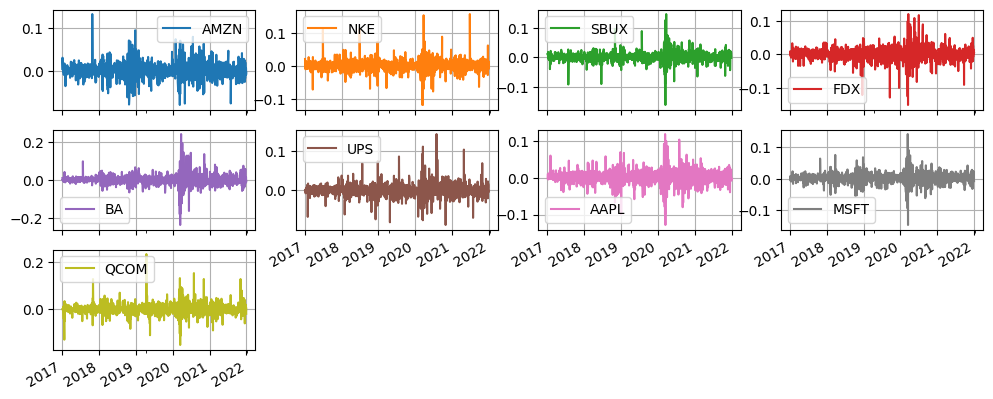

In [ ]:
# plot the trend by month
prep_data.plot(subplots=True,
        grid=True, 
        layout=(3,4),
        figsize=(12,5))
plt.show()

## 1.3 - Discussion of the Plots

---TBF



# 2 - Optimization Model



In [ ]:
Avg_Return = pd.DataFrame(np.mean(prep_data) ,columns=["Avg_Return"])
print(Avg_Return)
Std_Dev_Return = pd.DataFrame(np.std(prep_data) ,columns=["Std_Dev_Return"])
print(Std_Dev_Return)

      Avg_Return
AMZN    0.001364
NKE     0.001140
SBUX    0.000818
FDX     0.000528
BA      0.000704
UPS     0.000762
AAPL    0.001677
MSFT    0.001554
QCOM    0.001224
      Std_Dev_Return
AMZN        0.018538
NKE         0.018399
SBUX        0.017350
FDX         0.021118
BA          0.029664
UPS         0.017314
AAPL        0.019181
MSFT        0.017316
QCOM        0.023869


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
# here's the covariance matrix
Covariance_matrix = prep_data.cov()
Covariance_matrix

,AMZN,NKE,SBUX,FDX,BA,UPS,AAPL,MSFT,QCOM
AMZN,0.000344,0.000117,0.000118,0.000150,0.000145,0.000116,0.000226,0.000226,0.000193
NKE,0.000117,0.000339,0.000161,0.000168,0.000235,0.000125,0.000159,0.000159,0.000166
SBUX,0.000118,0.000161,0.000301,0.000169,0.000262,0.000113,0.000162,0.000164,0.000171
FDX,0.000150,0.000168,0.000169,0.000446,0.000284,0.000238,0.000180,0.000171,0.000216
BA,0.000145,0.000235,0.000262,0.000284,0.000881,0.000158,0.000227,0.000211,0.000245
UPS,0.000116,0.000125,0.000113,0.000238,0.000158,0.000300,0.000146,0.000136,0.000168
AAPL,0.000226,0.000159,0.000162,0.000180,0.000227,0.000146,0.000368,0.000245,0.000249
MSFT,0.000226,0.000159,0.000164,0.000171,0.000211,0.000136,0.000245,0.000300,0.000232
QCOM,0.000193,0.000166,0.000171,0.000216,0.000245,0.000168,0.000249,0.000232,0.000570


In [ ]:
#correlation matrix
Corr_matrix = prep_data.corr()
Corr_matrix

,AMZN,NKE,SBUX,FDX,BA,UPS,AAPL,MSFT,QCOM
AMZN,1.000000,0.342127,0.365271,0.381791,0.264178,0.360118,0.633951,0.703346,0.436280
NKE,0.342127,1.000000,0.502460,0.430822,0.430646,0.392967,0.451423,0.497948,0.377967
SBUX,0.365271,0.502460,1.000000,0.461297,0.508633,0.377508,0.486294,0.544911,0.412087
FDX,0.381791,0.430822,0.461297,1.000000,0.453348,0.649631,0.444002,0.468547,0.428724
BA,0.264178,0.430646,0.508633,0.453348,1.000000,0.306549,0.398806,0.410549,0.345735
UPS,0.360118,0.392967,0.377508,0.649631,0.306549,1.000000,0.439078,0.451816,0.405280
AAPL,0.633951,0.451423,0.486294,0.444002,0.398806,0.439078,1.000000,0.737204,0.543889
MSFT,0.703346,0.497948,0.544911,0.468547,0.410549,0.451816,0.737204,1.000000,0.560729
QCOM,0.436280,0.377967,0.412087,0.428724,0.345735,0.405280,0.543889,0.560729,1.000000


## Build non-linear optimization model

In [ ]:
# creating covariance table on stock return dataframe
df_cov = prep_data.cov()
print('Covariance Matrix:')
print(df_cov)
print('\n') # return/blank line

# create the average of each stock
# these are the objective function COEFFICIENTS!
df_return = prep_data.mean()
print('Average Return:')
print(df_return)

Covariance Matrix:
          AMZN       NKE      SBUX       FDX        BA       UPS      AAPL  \
AMZN  0.000344  0.000117  0.000118  0.000150  0.000145  0.000116  0.000226   
NKE   0.000117  0.000339  0.000161  0.000168  0.000235  0.000125  0.000159   
SBUX  0.000118  0.000161  0.000301  0.000169  0.000262  0.000113  0.000162   
FDX   0.000150  0.000168  0.000169  0.000446  0.000284  0.000238  0.000180   
BA    0.000145  0.000235  0.000262  0.000284  0.000881  0.000158  0.000227   
UPS   0.000116  0.000125  0.000113  0.000238  0.000158  0.000300  0.000146   
AAPL  0.000226  0.000159  0.000162  0.000180  0.000227  0.000146  0.000368   
MSFT  0.000226  0.000159  0.000164  0.000171  0.000211  0.000136  0.000245   
QCOM  0.000193  0.000166  0.000171  0.000216  0.000245  0.000168  0.000249   

          MSFT      QCOM  
AMZN  0.000226  0.000193  
NKE   0.000159  0.000166  
SBUX  0.000164  0.000171  
FDX   0.000171  0.000216  
BA    0.000211  0.000245  
UPS   0.000136  0.000168  
AAPL  0.000

In [ ]:
from pyomo.environ import *
model = ConcreteModel()

# from pyomo.environ import *
# m = ConcreteModel()

# defining variables
# each one is a stock (Amazon,Nike, Starbucks, Fedex, Boeing, UPS, Apple, Microsoft, Qualcomm)
model.Amazon = Var(within=NonNegativeReals, bounds=(0,1))
model.Nike = Var(within=NonNegativeReals, bounds=(0,1))
model.Starbucks= Var(within=NonNegativeReals, bounds=(0,1))
model.Fedex = Var(within=NonNegativeReals, bounds=(0,1))
model.Boeing = Var(within=NonNegativeReals, bounds=(0,1))
model.UPS = Var(within=NonNegativeReals, bounds=(0,1))
model.Apple = Var(within=NonNegativeReals, bounds=(0,1))
model.Microsoft = Var(within=NonNegativeReals, bounds=(0,1))
model.Qualcomm = Var(within=NonNegativeReals, bounds=(0,1))

# BINARY
model.AmazonY = Var(within=Binary)
model.NikeY = Var(within=Binary)
model.StarbucksY = Var(within=Binary)
model.FedexY = Var(within=Binary)
model.BoeingY = Var(within=Binary)
model.UPSY = Var(within=Binary)
model.AppleY = Var(within=Binary)
model.MicrosoftY = Var(within=Binary)
model.QualcommY = Var(within=Binary)



In [ ]:
# Only select one from each sector
model.c1= Constraint(expr= model.AmazonY + model.NikeY + model.StarbucksY == 1 )
model.c2= Constraint(expr= model.FedexY + model.BoeingY + model.UPSY == 1 )
model.c3= Constraint(expr= model.AppleY + model.MicrosoftY + model.QualcommY == 1 )

In [ ]:
# these previous demand costraints are rewritten as LINKING CONSTRAINTS
# which can help us decide if we should even be in that product line!
model.link1 = Constraint(expr = model.Amazon - 1*model.AmazonY <= 0) 
model.link2 = Constraint(expr = model.Nike - 1*model.NikeY <= 0) 
model.link3 = Constraint(expr = model.Starbucks - 1*model.StarbucksY <= 0) 
model.link4 = Constraint(expr = model.Fedex - 1*model.FedexY <= 0) 
model.link5 = Constraint(expr = model.Boeing - 1*model.BoeingY <= 0) 
model.link6 = Constraint(expr = model.UPS - 1*model.UPSY <= 0) 
model.link7 = Constraint(expr = model.Apple - 1*model.AppleY <= 0) 
model.link8 = Constraint(expr = model.Microsoft - 1*model.MicrosoftY <= 0) 
model.link9 = Constraint(expr = model.Qualcomm- 1*model.QualcommY <= 0) 

In [ ]:
# declare objective
model.objective = Objective(expr =               
                        model.AmazonY*model.Amazon*df_return[0] + 
                        model.NikeY*model.Nike*df_return[1] + 
                        model.StarbucksY*model.Starbucks*df_return[2] +
                        model.FedexY*model.Fedex*df_return[3] + 
                        model.BoeingY*model.Boeing*df_return[4]+
                        model.UPSY*model.UPS*df_return[5]+
                        model.AppleY*model.Apple*df_return[6]+
                        model.MicrosoftY*model.Microsoft*df_return[7]+
                        model.QualcommY*model.Qualcomm*df_return[8],
                        sense=maximize) # We want to maximise our returns

# declare constraints
# 1. Sum of all porportions = 1
model.sum_proportions = Constraint(expr = model.Amazon +model.Nike+ model.Starbucks+model.Fedex+model.Boeing+model.UPS+model.Apple+ model.Microsoft+ model.Qualcomm == 1)

# NOTE: There is no minimum return

model.total_risk = Constraint(expr = model.Amazon + model.Nike + model.Starbucks + model.Fedex + model.Boeing + model.UPS + model.Apple + model.Microsoft + model.Qualcomm >= 0.0)

In [ ]:
#Addressing risk

#creating calculations table for calculate the risk
# 3. Calculate risk
def calc_risk(model):
  variables = model.Amazon, model.Nike,model.Starbucks,model.Fedex,model.Boeing,model.UPS,model.Apple,model.Microsoft,model.Qualcomm
  tickers = ['AMZN','NKE','SBUX','FDX','BA','UPS','AAPL','MSFT','QCOM']
  risk_exp = 0
  for i in range(len(variables)):
    for j in range(len(variables)):
      risk_exp += variables[i]*df_cov.at[tickers[i],tickers[j]]*variables[j]
  return risk_exp

# We are going to use this expression to compute the risk
expr_risk = calc_risk(model)

# 3. Max risk should be less than 0.01
#max_risk = 0.02
max_risk = 0.004
# Sequence of risk levels
risk_limits = np.arange(0.0001, max_risk, 0.00002) # take tiny steps
#risk_limits = np.arange(0.0002, max_risk, 0.000005)
risk_limits



array([0.0001 , 0.00012, 0.00014, 0.00016, 0.00018, 0.0002 , 0.00022,
       0.00024, 0.00026, 0.00028, 0.0003 , 0.00032, 0.00034, 0.00036,
       0.00038, 0.0004 , 0.00042, 0.00044, 0.00046, 0.00048, 0.0005 ,
       0.00052, 0.00054, 0.00056, 0.00058, 0.0006 , 0.00062, 0.00064,
       0.00066, 0.00068, 0.0007 , 0.00072, 0.00074, 0.00076, 0.00078,
       0.0008 , 0.00082, 0.00084, 0.00086, 0.00088, 0.0009 , 0.00092,
       0.00094, 0.00096, 0.00098, 0.001  , 0.00102, 0.00104, 0.00106,
       0.00108, 0.0011 , 0.00112, 0.00114, 0.00116, 0.00118, 0.0012 ,
       0.00122, 0.00124, 0.00126, 0.00128, 0.0013 , 0.00132, 0.00134,
       0.00136, 0.00138, 0.0014 , 0.00142, 0.00144, 0.00146, 0.00148,
       0.0015 , 0.00152, 0.00154, 0.00156, 0.00158, 0.0016 , 0.00162,
       0.00164, 0.00166, 0.00168, 0.0017 , 0.00172, 0.00174, 0.00176,
       0.00178, 0.0018 , 0.00182, 0.00184, 0.00186, 0.00188, 0.0019 ,
       0.00192, 0.00194, 0.00196, 0.00198, 0.002  , 0.00202, 0.00204,
       0.00206, 0.00

In [ ]:
risk_limits.shape

(195,)

## 2.1 Model execution

In [ ]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'

In [ ]:
from pyomo.opt import SolverStatus, TerminationCondition

# updating risk contraint for each limit and then solving the problem
param_analysis = {} # key=risk, value =stock allocations 
returns = {} # key=risk, value = return
for r in risk_limits:

  # Remove constraint to avoid error messages
  model.del_component(model.total_risk)
  model.total_risk = Constraint(expr = expr_risk <= r)

  # run solver
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(model)

  # MAY NOT FILTER ALL INFEASIBLE OUTCOMES IN REAL-WORLD INSTANCES
  # # If solution is not feasible, ignore this run
  # if result.solver.termination_condition == TerminationCondition.infeasible:
  #   continue

  # If solution is not feasible, ignore this run
  if result.solver.termination_condition != TerminationCondition.optimal:
    continue
  result = result.write()

  # store our allocation proportions 
  param_analysis[r] = [model.Amazon(), model.Nike(),model.Starbucks(),model.Fedex(),model.Boeing(),model.UPS(),model.Apple(),model.Microsoft(),model.Qualcomm()]
  # store our returns
  returns[r] =  model.Amazon()*df_return[0] + model.Nike()*df_return[1] + model.Starbucks()*df_return[2] +model.Fedex()*df_return[3] + model.Boeing()*df_return[4]+ model.UPS()*df_return[5]+ model.Apple()*df_return[6]+ model.Microsoft()*df_return[7]+ model.Qualcomm()*df_return[8]

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


Streaming output truncated to the last 5000 lines.
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.02074885368347168
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 14
  Number of variables: 18
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------

In [ ]:
# # generating the dataframe for proportions of the portfolio for each risk limit
# param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
# param_analysis = param_analysis[['Apple']] # selecting only the 'Apple' column
# param_analysis.plot()
# plt.title('Optimal Stock Allocation for Different Risk Levels - Apple')
# plt.show()

In [ ]:
# # generating the dataframe for proportions of the portfolio for each risk limit
# param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')

# if 'Apple' in param_analysis.columns:
#     # selecting only the 'Apple' column
#     param_analysis = param_analysis[['Apple']]
#     param_analysis.plot()
#     plt.title('Optimal Stock Allocation for Different Risk Levels - Apple')
#     plt.show()
# else:
#     print("Error: 'Apple' column not found in dataframe.")


In [ ]:
# dftmp = param_analysis.drop('Qualcomm', axis=1)

In [ ]:
# # generating the dataframe for proportions of the portfolio for each risk limit
# dftmp = pd.DataFrame.from_dict(dftmp, orient='index')
# dftmp.columns = [ 'Amazon', 'Nike', 'Starbucks', 'FedEx', 'Boeing','UPS','Apple','Microsoft']
# dftmp.plot()
# plt.title('Optimal Stock Allocation for Different Risk Levels')
# plt.show()

In [ ]:
param_analysis

{0.00017999999999999998: [0.08510206150643473,
  0.20006975795242027,
  0.14953113611509744,
  1.8363451090486046e-06,
  1.2430744869617907e-06,
  0.30706178860262273,
  2.152000332139644e-06,
  0.258228134276449,
  1.8901270477431447e-06],
 0.00019999999999999998: [4.834235730659839e-06,
  0.2659800057408461,
  1.9852639318890985e-05,
  2.430979454487707e-06,
  1.8480967113378969e-06,
  0.2912673515654793,
  1.823173115479575e-06,
  0.4427200987629114,
  1.7548064322788227e-06],
 0.00021999999999999998: [1.7502117625170085e-06,
  0.2414279232250003,
  2.883626719625535e-06,
  2.204397574267334e-06,
  1.353217424772575e-06,
  0.1388618678889003,
  1.1511171857523972e-06,
  0.6196996997088903,
  1.1666065423165711e-06],
 0.00023999999999999998: [1.8851437063981333e-06,
  0.22702504355481007,
  2.2978919887783265e-06,
  2.4534662205916247e-06,
  1.9500093934070523e-06,
  0.0491809309415693,
  1.3225641679279491e-06,
  0.7237827624158075,
  1.3540123360795736e-06],
 0.00026: [1.9177549239

## 2.2 Plot with allocation of stocks

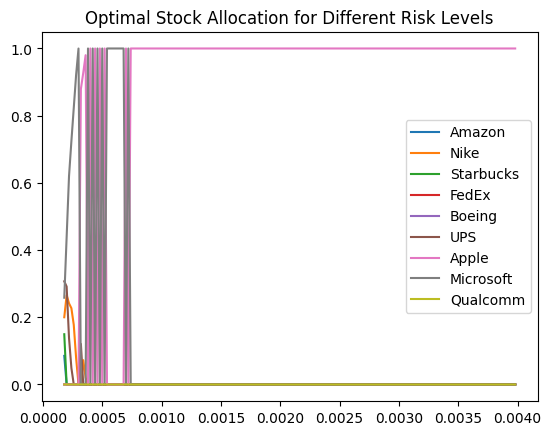

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
# param_analysis = a
param_analysis.columns = ['Amazon', 'Nike', 'Starbucks', 'FedEx', 'Boeing','UPS','Apple','Microsoft','Qualcomm']
param_analysis.plot()
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.show()

In [ ]:
# they all sum to one! --- TBC
pd.DataFrame(param_analysis.sum(axis=1)).describe()

,0
count,1.910000e+02
mean,1.000000e+00
std,9.597931e-17
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


## 2.3 Plot with efficient frontier




In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward) 

[0.00017999999999999998, 0.00019999999999999998, 0.00021999999999999998, 0.00023999999999999998, 0.00026, 0.00028, 0.0003, 0.00031999999999999997, 0.00033999999999999997, 0.00035999999999999997, 0.00037999999999999997, 0.00039999999999999996, 0.00041999999999999996, 0.00043999999999999996, 0.00045999999999999996, 0.00047999999999999996, 0.0005, 0.00052, 0.00054, 0.00056, 0.00058, 0.0006000000000000001, 0.00062, 0.0006399999999999999, 0.00066, 0.00068, 0.0007, 0.0007199999999999999, 0.00074, 0.00076, 0.00078, 0.0007999999999999999, 0.00082, 0.00084, 0.00086, 0.0008799999999999999, 0.0009, 0.00092, 0.00094, 0.0009599999999999999, 0.00098, 0.001, 0.0010199999999999999, 0.00104, 0.00106, 0.00108, 0.0011, 0.00112, 0.00114, 0.00116, 0.0011799999999999998, 0.0012, 0.00122, 0.00124, 0.00126, 0.0012799999999999999, 0.0013, 0.00132, 0.0013399999999999998, 0.0013599999999999999, 0.00138, 0.0014, 0.00142, 0.0014399999999999999, 0.00146, 0.00148, 0.0014999999999999998, 0.0015199999999999999, 0.0015

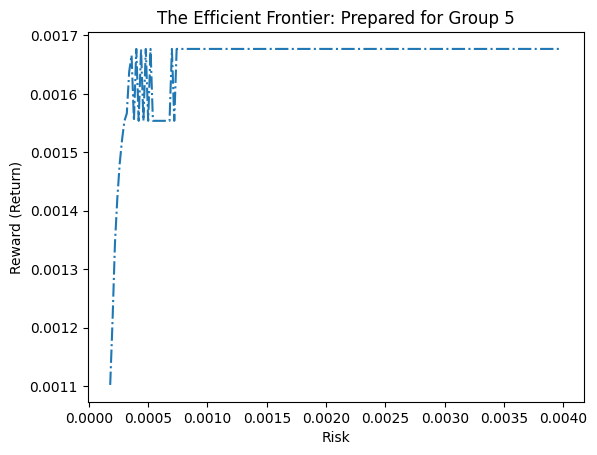

In [ ]:
# plot! pylab makes it easy
from pylab import *
plot(risk, reward, '-.')
title('The Efficient Frontier: Prepared for Group 5')
xlabel('Risk')
ylabel('Reward (Return)')
plt.show()

## 2.4 Portfolio selection

In [ ]:
# # select one portfolio allocation returned by your model containing exactly three assets
# for i in param_analysis.index:
#   s=0  # count the weight great than 0
#   for j in param_analysis.columns: # for each asset
#     if param_analysis.loc[i,j]>=0.001:   ## if the weight less than 0.001, we assume it equals 0
#       s+=1
#   if s==3: # containing exact three assets
#     print('risk of the portfolio:',i)
#     print('weight for this portfolio:')
#     print(param_analysis.loc[i,])
#     print('average return of the portfolio:',returns[i])

In [ ]:
# check which stocks are selected by the model

print("Objective Function : ",model.objective()) 
print("Amazon :  ", model.AmazonY())
print("Nike : ", model.NikeY())
print("Starbucks : ", model.StarbucksY())
print("FedEx Corporation : ", model.FedexY())
print("The Boeing Company : ", model.BoeingY())
print("United Parcel Service(UPS) = ", model.UPSY())
print("Apple :  ", model.AppleY())
print("Microsoft : ", model.MicrosoftY())
print("Qualcomm : ", model.QualcommY())
# We include AMZN, FDX, AAPL in our portfolio as they are really close to 1

Objective Function :  0.0016767835473512063
Amazon :   0.32734101256544135
Nike :  0.33958985482744125
Starbucks :  0.33306913260711746
FedEx Corporation :  0.33053542038673117
The Boeing Company :  0.3345069024537552
United Parcel Service(UPS) =  0.3349576771595137
Apple :   0.9999924953250007
Microsoft :  3.763874158716251e-06
Qualcomm :  3.740800840674545e-06


In [ ]:
# check the result of our allocation
print('Objective=',model.objective()) 
print("Nike : ", model.Nike())
print("Apple : ", model.Apple())
print("UPS : ", model.UPS())
print("Sbux : ", model.Starbucks())
print("Amazon : ", model.Amazon())
print("Fedex : ", model.Fedex())
print("Boeing : ", model.Boeing())
print("Microsoft : ", model.Microsoft())
print("Qualcomm : ", model.Qualcomm())

portfolio = model.Nike() + model.Apple() + model.UPS()
print('Nike + Apple + UPS : ',portfolio)

Objective= 0.0016767835473512063
Nike :  2.5350022296232128e-06
Apple :  0.9999823938245908
UPS :  2.4198434118653366e-06
Sbux :  2.203938842297462e-06
Amazon :  3.534071296453574e-06
Fedex :  2.190990835334466e-06
Boeing :  2.3463656781370164e-06
Microsoft :  1.1685268761696543e-06
Qualcomm :  1.2074362392480472e-06
Nike + Apple + UPS :  0.9999873486702322


# 3 - Analysis

## 3.1 - Buy-and-Hold strategy for the MPT portfolio

In [ ]:
# three sectors:
tickers_ = ['NKE','AAPL','UPS']
dow_prices = {ticker : si.get_data(ticker,start_date = '01/01/2017',end_date='12/31/2021',interval='1d') for ticker in tickers_}

# let's extract just the data we need (adjclose)
# get the adjclose price for the MSFT (one sample)
data = pd.DataFrame(dow_prices['NKE']['adjclose']).rename(columns = {"adjclose":"NKE"})

# combine all the tickers (all the rest of the samples)
for i in tickers_[0:]:
  data[i] = pd.DataFrame(dow_prices[i]['adjclose'])

data.head()

,NKE,AAPL,UPS
2017-01-03,48.682556,27.133324,94.947655
2017-01-04,49.703396,27.102961,94.972427
2017-01-05,49.694042,27.240789,95.021927
2017-01-06,50.490120,27.544472,95.211693
2017-01-09,49.993748,27.796766,94.691917


In [ ]:
#Add 'Buy and Hold' return

# Create the logclose price and calculate return for each stock
# for loop with f-strings to create logclose columns
for x in ['NKE','AAPL','UPS']:
  data[f'logClose_{x}'] = np.log(data[f'{x}'])

# for loop with f-strings to create return columns
for x in ['NKE','AAPL','UPS']:
  data[f'return_{x}'] = data[f'logClose_{x}'].diff()

# set the first record to 0
for x in ['NKE','AAPL','UPS']:
  data.loc['2021-12-30',f'return_{x}'] = 0.0
  data.loc['2021-12-31',f'return_{x}'] = 0.0
  data.loc['2017-01-03',f'return_{x}'] = 0.0

data.head()

,NKE,AAPL,UPS,logClose_NKE,logClose_AAPL,logClose_UPS,return_NKE,return_AAPL,return_UPS
2017-01-03,48.682556,27.133324,94.947655,3.885321,3.300763,4.553326,0.000000,0.000000,0.000000
2017-01-04,49.703396,27.102961,94.972427,3.906073,3.299643,4.553587,0.020752,-0.001120,0.000261
2017-01-05,49.694042,27.240789,95.021927,3.905885,3.304715,4.554108,-0.000188,0.005072,0.000521
2017-01-06,50.490120,27.544472,95.211693,3.921778,3.315802,4.556103,0.015893,0.011086,0.001995
2017-01-09,49.993748,27.796766,94.691917,3.911898,3.324920,4.550629,-0.009880,0.009118,-0.005474


In [ ]:
#Add Return value, aggregate value of each stock and aggregate value of portfolio
# Bringing in the porportion of each stock that consists of our portfolio and our total investment

Nike_allocation = 0.179 # allocation of AMZN
Apple_allocation = 0.411 # allocation of FDX
UPS_allocation = 0.41 # allocation of AAPL
total_amt = 100000 # total investment

# create the daily money amount volatility columns of each stock
data['returnVal_NKE'] = Nike_allocation* total_amt * data['return_NKE']
data['returnVal_AAPL'] = Apple_allocation * total_amt * data['return_AAPL']
data['returnVal_UPS'] = UPS_allocation* total_amt * data['return_UPS']


# create the aggregate value columns of each stock
data['aggVal_NKE'] = data['returnVal_NKE'] + (Nike_allocation * total_amt)
data['aggVal_AAPL'] = data['returnVal_AAPL'] + (Apple_allocation * total_amt)
data['aggVal_UPS'] = data['returnVal_UPS'] + (UPS_allocation * total_amt)

# create the aggregate value columns of portfolio
data['aggVal_portfolio'] = data['aggVal_NKE'] + data['aggVal_AAPL'] + data['aggVal_UPS']

# check work
data.head()

,NKE,AAPL,UPS,logClose_NKE,logClose_AAPL,logClose_UPS,return_NKE,return_AAPL,return_UPS,returnVal_NKE,returnVal_AAPL,returnVal_UPS,aggVal_NKE,aggVal_AAPL,aggVal_UPS,aggVal_portfolio
2017-01-03,48.682556,27.133324,94.947655,3.885321,3.300763,4.553326,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17900.000000,41100.000000,41000.000000,100000.000000
2017-01-04,49.703396,27.102961,94.972427,3.906073,3.299643,4.553587,0.020752,-0.001120,0.000261,371.469420,-46.018006,10.695851,18271.469420,41053.981994,41010.695851,100336.147264
2017-01-05,49.694042,27.240789,95.021927,3.905885,3.304715,4.554108,-0.000188,0.005072,0.000521,-3.368902,208.479427,21.363582,17896.631098,41308.479427,41021.363582,100226.474107
2017-01-06,50.490120,27.544472,95.211693,3.921778,3.315802,4.556103,0.015893,0.011086,0.001995,284.477925,455.650707,81.798430,18184.477925,41555.650707,41081.798430,100821.927062
2017-01-09,49.993748,27.796766,94.691917,3.911898,3.324920,4.550629,-0.009880,0.009118,-0.005474,-176.846996,374.743241,-224.438537,17723.153004,41474.743241,40775.561463,99973.457708


In [ ]:
data.head()

,NKE,AAPL,UPS,logClose_NKE,logClose_AAPL,logClose_UPS,return_NKE,return_AAPL,return_UPS,returnVal_NKE,returnVal_AAPL,returnVal_UPS,aggVal_NKE,aggVal_AAPL,aggVal_UPS,aggVal_portfolio
2017-01-03,48.682556,27.133324,94.947655,3.885321,3.300763,4.553326,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17900.000000,41100.000000,41000.000000,100000.000000
2017-01-04,49.703396,27.102961,94.972427,3.906073,3.299643,4.553587,0.020752,-0.001120,0.000261,371.469420,-46.018006,10.695851,18271.469420,41053.981994,41010.695851,100336.147264
2017-01-05,49.694042,27.240789,95.021927,3.905885,3.304715,4.554108,-0.000188,0.005072,0.000521,-3.368902,208.479427,21.363582,17896.631098,41308.479427,41021.363582,100226.474107
2017-01-06,50.490120,27.544472,95.211693,3.921778,3.315802,4.556103,0.015893,0.011086,0.001995,284.477925,455.650707,81.798430,18184.477925,41555.650707,41081.798430,100821.927062
2017-01-09,49.993748,27.796766,94.691917,3.911898,3.324920,4.550629,-0.009880,0.009118,-0.005474,-176.846996,374.743241,-224.438537,17723.153004,41474.743241,40775.561463,99973.457708


In [ ]:
# reset index and name it date

data.reset_index()
df = data.rename(columns={'index': 'date'})

# subset the first day of each month
#new_data = df.resample('MS').first()

In [ ]:
df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-17',
               ...
               '2021-12-17', '2021-12-20', '2021-12-21', '2021-12-22',
               '2021-12-23', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=1259, freq=None)

In [1]:
df.to_pickle('test.zip')

NameError: ignored

In [ ]:
new_data = df.resample('MS').first()

ImportError: ignored

In [ ]:
#Aggregate Value on the first day of each month

# create a table showing the aggregate value of the whole porfolio
new_data = new_data.drop(columns=new_data.columns.difference(['aggVal_portfolio']))
new_data
# for buy and hold case, amount of money invested on the first day of each month equals to aggregate value on the first day

NameError: ignored

## 3.2 - Momentum trading strategy for each stock in the MPT portfolio

### Stock 1

In [ ]:
# ticker = AMZN, Bunge Limited
ticker1= 'AMZN'
AMZN_prices = si.get_data(ticker1,start_date = '11/29/2021',end_date='12/31/2022',interval='1d')

# We only need the adjusted close price
AMZN_prices.drop(columns=['open', 'high','low','close','volume','ticker'], inplace = True)

# change the sequence or columns
AMZN_prices = AMZN_prices[['adjclose']]

# rename the columns
AMZN_prices.columns = ['Adjclose']

# rolled back (no data leakage) 
# since this cell is run after, this overwrites the previous data leakage
# you can comment out the cell above and run all if you are nervous!
AMZN_prices['AMZN_8-day'] = AMZN_prices['Adjclose'].rolling(8).mean().shift() # shift() shifts the rolling mean series backward by one time period
AMZN_prices['AMZN_21-day'] = AMZN_prices['Adjclose'].rolling(21).mean().shift()

# Drop nulls
AMZN_prices.dropna(inplace=True)

# check work
AMZN_prices.head()

,Adjclose,AMZN_8-day,AMZN_21-day
2021-12-29,169.201004,169.852562,171.802097
2021-12-30,168.644501,169.893812,171.379359
2021-12-31,166.716995,169.722187,171.059883
2022-01-03,170.404495,169.676937,170.799454
2022-01-04,167.522003,169.675373,170.729763


In [ ]:
AMZN_prices['logClose'] = np.log(AMZN_prices['Adjclose']) # price will always be positive, so this operation is well-defined
AMZN_prices['return'] = AMZN_prices['logClose'].diff() # the difference will be positive or negative

# This part is a contingency plan
AMZN_prices.loc["2021-12-29",'return'] = 0.0
AMZN_prices.loc["2021-12-30",'return'] = 0.0

# 01-01-2022 stock market is not open, so for now we force the buy-in date to be 12-31-2021, subject to Professor's confirmation
AMZN_prices.loc["2021-12-31",'return'] = 0.0
# check our work
AMZN_prices.head()

,Adjclose,AMZN_8-day,AMZN_21-day,logClose,return
2021-12-29,169.201004,169.852562,171.802097,5.131087,0.000000
2021-12-30,168.644501,169.893812,171.379359,5.127793,0.000000
2021-12-31,166.716995,169.722187,171.059883,5.116298,0.000000
2022-01-03,170.404495,169.676937,170.799454,5.138175,0.021877
2022-01-04,167.522003,169.675373,170.729763,5.121115,-0.017060


In [ ]:
# the np.where() function is similar to the Excel =IF() statement
AMZN_prices['invested'] = np.where(AMZN_prices['AMZN_8-day'] > AMZN_prices['AMZN_21-day'], 1, 0) # when the 8 days moving avg is greater than 21 moving avg, we are holding!
print('8-day moving greater than 21-day moving average then it is a 1, otherwise 0')
print(AMZN_prices['invested'].value_counts(),'\n')

# the variable signal tells you when you buy and sell
# we will use it to make red and green triangles
AMZN_prices['signal'] = AMZN_prices['invested'].diff()
print('0 means we hold, -1 represents the days we sell, 1 represents the days we buy')
print(AMZN_prices['signal'].value_counts(),'\n') 

# the first buy point is currently 2021-12-31, even though the first record is 2021-12-29	
AMZN_prices.loc["2021-12-29",'signal'] = 0.0 # null value, but we hard code it 0 here, not buying yet

# 2021-12-30 has value 0, we don't need to do change
AMZN_prices.loc["2021-12-31",'signal'] = 1.0 # time to buy

# Run this code if you wish to see all the buy and sell signal date
# AMZN_prices[AMZN_prices['signal'].isin([1,-1])]

# The 'system_return' tells you how much money you would have made
# using your momentum trading algorithm!
AMZN_prices['system_return'] = AMZN_prices['invested'] * AMZN_prices['return']

# What was the return of this trategy? not bad!

print('return rate of AMZN:',np.exp(np.sum(AMZN_prices['system_return'])) -1)

8-day moving greater than 21-day moving average then it is a 1, otherwise 0
0    175
1     79
Name: invested, dtype: int64 

0 means we hold, -1 represents the days we sell, 1 represents the days we buy
 0.0    241
 1.0      6
-1.0      6
Name: signal, dtype: int64 

return rate of AMZN: -0.2955836370458427


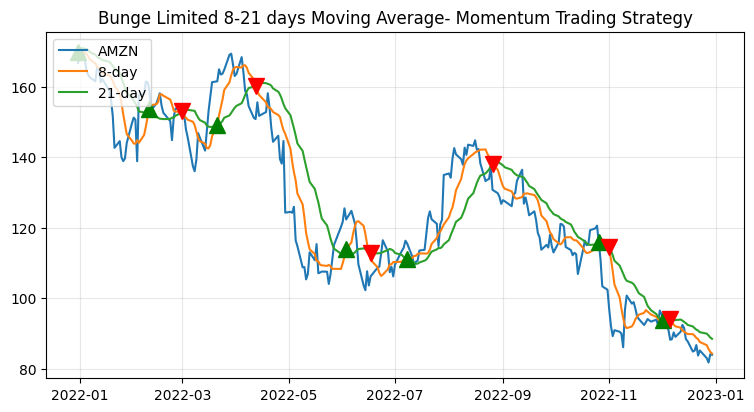

In [ ]:
# imagine where you would put markers on the plot 
# for buy vs. sell...

# the -252: shows the last 252 days
plt.rcParams['figure.figsize'] = 9,4.5
plt.title('Bunge Limited 8-21 days Moving Average- Momentum Trading Strategy')
plt.grid(True, alpha = .3)
plt.plot(AMZN_prices.iloc[-252:]['Adjclose'], label = 'AMZN') # actual value
plt.plot(AMZN_prices.iloc[-252:]['AMZN_8-day'], label = '8-day') # 8-day average
plt.plot(AMZN_prices.iloc[-252:]['AMZN_21-day'], label = '21-day') # 21-day average
plt.plot(AMZN_prices[-252:].loc[AMZN_prices.signal == 1].index, AMZN_prices[-252:]['AMZN_8-day'][AMZN_prices.signal == 1], '^',
         color = 'g', markersize = 12)
plt.plot(AMZN_prices[-252:].loc[AMZN_prices.signal == -1].index, AMZN_prices[-252:]['AMZN_21-day'][AMZN_prices.signal == -1], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

### Stock 2

In [ ]:
# ticker = amt, Bunge Limited
ticker2= 'FDX'
FDX_prices = si.get_data(ticker2,start_date = '11/29/2021',end_date='12/31/2022',interval='1d')

# We only need the adjusted close price
FDX_prices.drop(columns=['open', 'high','low','close','volume','ticker'], inplace = True)

# change the sequence or columns
FDX_prices = FDX_prices[['adjclose']]

# rename the columns
FDX_prices.columns = ['Adjclose']

# rolled back (no data leakage) 
# since this cell is run after, this overwrites the previous data leakage
# you can comment out the cell above and run all if you are nervous!
FDX_prices['FDX_8-day'] = FDX_prices['Adjclose'].rolling(8).mean().shift() # shift() shifts the rolling mean series backward by one time period
FDX_prices['FDX_21-day'] = FDX_prices['Adjclose'].rolling(21).mean().shift()

# Drop nulls
FDX_prices.dropna(inplace=True)

# check our work
FDX_prices.head()

,Adjclose,FDX_8-day,FDX_21-day
2021-12-29,250.836563,243.882288,237.564517
2021-12-30,251.878906,246.192263,238.383538
2021-12-31,251.956863,247.195644,239.723910
2022-01-03,251.869186,248.789616,241.187775
2022-01-04,258.064850,249.593300,242.299689


In [ ]:
FDX_prices['logClose'] = np.log(FDX_prices['Adjclose']) # price will always be positive, so this operation is well-defined
FDX_prices['return'] = FDX_prices['logClose'].diff() # the difference will be positive or negative

# This part is a contingency plan
FDX_prices.loc["2021-12-29",'return'] = 0.0
FDX_prices.loc["2021-12-30",'return'] = 0.0

# 01-01-2022 stock market is not open, so for now we force the buy-in date to be 12-31-2021, subject to Professor's confirmation
FDX_prices.loc["2021-12-31",'return'] = 0.0

# check our work
FDX_prices.head()

,Adjclose,FDX_8-day,FDX_21-day,logClose,return
2021-12-29,250.836563,243.882288,237.564517,5.524802,0.000000
2021-12-30,251.878906,246.192263,238.383538,5.528948,0.000000
2021-12-31,251.956863,247.195644,239.723910,5.529258,0.000000
2022-01-03,251.869186,248.789616,241.187775,5.528910,-0.000348
2022-01-04,258.064850,249.593300,242.299689,5.553211,0.024301


In [ ]:
# the np.where() function is similar to the Excel =IF() statement
FDX_prices['invested'] = np.where(FDX_prices['FDX_8-day'] > FDX_prices['FDX_21-day'], 1, 0) # when the 8 days moving avg is greater than 21 moving avg, we are holding!
print('8-day moving greater than 21-day moving average then it is a 1, otherwise 0')
print(FDX_prices['invested'].value_counts(),'\n')

# the variable signal tells you when you buy and sell
# we will use it to make red and green triangles
FDX_prices['signal'] = FDX_prices['invested'].diff()
print('0 means we hold, -1 represents the days we sell, 1 represents the days we buy')
print(FDX_prices['signal'].value_counts(),'\n') 

# the first buy point is currently 2021-12-31, even though the first record is 2021-12-29	
FDX_prices.loc["2021-12-29",'signal'] = 0.0 # null value, but we hard code it 0 here, not buying yet
FDX_prices.loc["2021-12-31",'signal'] = 1.0 # time to buy

# Run this code if you wish to see all the buy and sell signal date
#FDX_prices[FDX_prices['signal'].isin([1,-1])]

# The 'system_return' tells you how much money you would have made
# using your momentum trading algorithm!
FDX_prices['system_return'] = FDX_prices['invested'] * FDX_prices['return']

# What was the return of this trategy? 
print('return rate of AMZN:',np.exp(np.sum(FDX_prices['system_return'])) -1)
print('We are losing money on this stock!!')

8-day moving greater than 21-day moving average then it is a 1, otherwise 0
1    130
0    124
Name: invested, dtype: int64 

0 means we hold, -1 represents the days we sell, 1 represents the days we buy
 0.0    240
-1.0      7
 1.0      6
Name: signal, dtype: int64 

return rate of AMZN: 0.07053007239788123
We are losing money on this stock!!


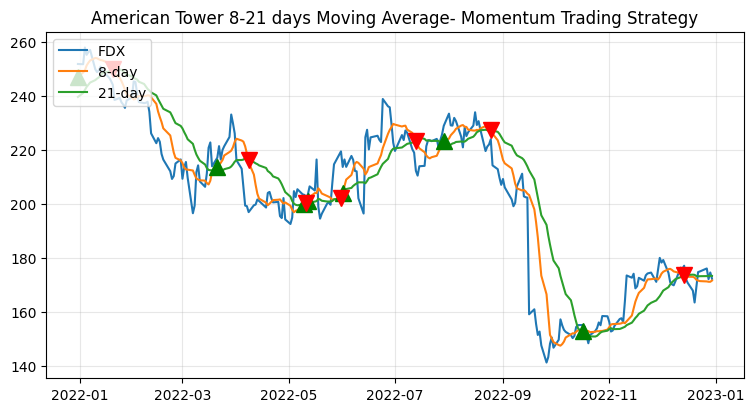

In [ ]:
# Visualize the buy and sell point
# the -252: shows the last 252 days
plt.rcParams['figure.figsize'] = 9,4.5
plt.title('American Tower 8-21 days Moving Average- Momentum Trading Strategy')
plt.grid(True, alpha = .3)
plt.plot(FDX_prices.iloc[-252:]['Adjclose'], label = 'FDX') # actual value
plt.plot(FDX_prices.iloc[-252:]['FDX_8-day'], label = '8-day') # 8-day average
plt.plot(FDX_prices.iloc[-252:]['FDX_21-day'], label = '21-day') # 21-day average
plt.plot(FDX_prices[-252:].loc[FDX_prices.signal == 1].index, FDX_prices[-252:]['FDX_8-day'][FDX_prices.signal == 1], '^',
         color = 'g', markersize = 12)
plt.plot(FDX_prices[-252:].loc[FDX_prices.signal == -1].index, FDX_prices[-252:]['FDX_21-day'][FDX_prices.signal == -1], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

### Stock 3

In [ ]:
# ticker = amt, Bunge Limited
ticker3= 'AAPL'
AAPL_prices = si.get_data(ticker3,start_date = '11/29/2021',end_date='12/31/2022',interval='1d')

# We only need the adjusted close price
AAPL_prices.drop(columns=['open', 'high','low','close','volume','ticker'], inplace = True)

# change the sequence or columns
AAPL_prices = AAPL_prices[['adjclose']]

# rename the columns
AAPL_prices.columns = ['Adjclose']

# rolled back (no data leakage) 
# since this cell is run after, this overwrites the previous data leakage
# you can comment out the cell above and run all if you are nervous!
AAPL_prices['AAPL_8-day'] = AAPL_prices['Adjclose'].rolling(8).mean().shift() # shift() shifts the rolling mean series backward by one time period
AAPL_prices['AAPL_21-day'] = AAPL_prices['Adjclose'].rolling(21).mean().shift()

# Drop nulls
AAPL_prices.dropna(inplace=True)

# check our work
AAPL_prices.head()

,Adjclose,AAPL_8-day,AAPL_21-day
2021-12-29,178.073044,173.437054,170.583717
2021-12-30,176.901642,174.320572,171.488505
2021-12-31,176.276230,175.196644,172.098315
2022-01-03,180.683868,176.167023,172.703398
2022-01-04,178.390701,177.286308,173.566113


In [ ]:
AAPL_prices['logClose'] = np.log(AAPL_prices['Adjclose']) # price will always be positive, so this operation is well-defined
AAPL_prices['return'] = AAPL_prices['logClose'].diff() # the difference will be positive or negative

# This part is a contingency plan
AAPL_prices.loc["2021-12-29",'return'] = 0.0
AAPL_prices.loc["2021-12-30",'return'] = 0.0

# 01-01-2022 stock market is not open, so for now we force the buy-in date to be 12-31-2021, subject to Professor's confirmation
AAPL_prices.loc["2021-12-31",'return'] = 0.0

# check our work
AAPL_prices.head()

,Adjclose,AAPL_8-day,AAPL_21-day,logClose,return
2021-12-29,178.073044,173.437054,170.583717,5.182194,0.000000
2021-12-30,176.901642,174.320572,171.488505,5.175594,0.000000
2021-12-31,176.276230,175.196644,172.098315,5.172052,0.000000
2022-01-03,180.683868,176.167023,172.703398,5.196749,0.024697
2022-01-04,178.390701,177.286308,173.566113,5.183976,-0.012773


In [ ]:
# the np.where() function is similar to the Excel =IF() statement
AAPL_prices['invested'] = np.where(AAPL_prices['AAPL_8-day'] > AAPL_prices['AAPL_21-day'], 1, 0) # when the 8 days moving avg is greater than 21 moving avg, we are holding!
print('8-day moving greater than 21-day moving average then it is a 1, otherwise 0')
print(AAPL_prices['invested'].value_counts(),'\n')

# the variable signal tells you when you buy and sell
# we will use it to make red and green triangles
AAPL_prices['signal'] = AAPL_prices['invested'].diff()
print('0 means we hold, -1 represents the days we sell, 1 represents the days we buy')
print(AAPL_prices['signal'].value_counts(),'\n') 

# the first buy point is currently 2021-12-31, even though the first record is 2021-12-29	
AAPL_prices.loc["2021-12-29",'signal'] = 0.0 # null value, but we hard code it 0 here, not buying yet
AAPL_prices.loc["2021-12-31",'signal'] = 1.0 # time to buy

# Run this code if you wish to see all the buy and sell signal date
# AAPL_prices[AAPL_prices['signal'].isin([1,-1])]

# The 'system_return' tells you how much money you would have made
# using your momentum trading algorithm!
AAPL_prices['system_return'] = AAPL_prices['invested'] * AAPL_prices['return']

# What was the return of this trategy? 
print('return rate of AMZN:',np.exp(np.sum(AAPL_prices['system_return'])) -1)
print('We are losing money on this stock!!')

8-day moving greater than 21-day moving average then it is a 1, otherwise 0
0    150
1    104
Name: invested, dtype: int64 

0 means we hold, -1 represents the days we sell, 1 represents the days we buy
 0.0    240
-1.0      7
 1.0      6
Name: signal, dtype: int64 

return rate of AMZN: -0.2612722969132939
We are losing money on this stock!!


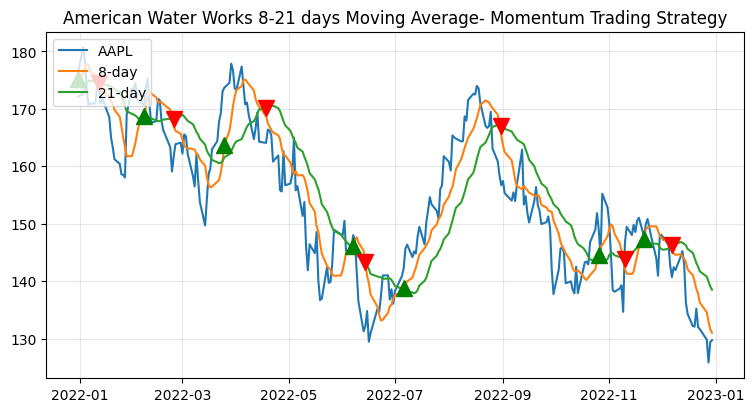

In [ ]:
# Visualize the buy and sell point
# the -252: shows the last 252 days
plt.rcParams['figure.figsize'] = 9,4.5
plt.title('American Water Works 8-21 days Moving Average- Momentum Trading Strategy')
plt.grid(True, alpha = .3)
plt.plot(AAPL_prices.iloc[-252:]['Adjclose'], label = 'AAPL') # actual value
plt.plot(AAPL_prices.iloc[-252:]['AAPL_8-day'], label = '8-day') # 8-day average
plt.plot(AAPL_prices.iloc[-252:]['AAPL_21-day'], label = '21-day') # 21-day average
plt.plot(AAPL_prices[-252:].loc[AAPL_prices.signal == 1].index, AAPL_prices[-252:]['AAPL_8-day'][AAPL_prices.signal == 1], '^',
         color = 'g', markersize = 12)
plt.plot(AAPL_prices[-252:].loc[AAPL_prices.signal == -1].index, AAPL_prices[-252:]['AAPL_21-day'][AAPL_prices.signal == -1], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

In [ ]:
#Aggregate entire portfolio value 

# Bringing in the porportion of each stock that consists of our portfolio and our total investment

AMZN_allocation = 0.179 # allocation of AMZN
FDX_allocation = 0.411 # allocation of FDX
AAPL_allocation = 0.41 # allocation of AAPL
total_amt = 100000 # total investment

# create the daily money amount volatility columns of each stock
# since it is momentum trading, we multiply system_return, not return!
AMZN_prices['returnVal_AMZN'] = AMZN_allocation * total_amt * AMZN_prices['system_return'] 
FDX_prices['returnVal_FDX'] = FDX_allocation * total_amt * FDX_prices['system_return']
AAPL_prices['returnVal_AAPL'] = AAPL_allocation * total_amt * FDX_prices['system_return']


# create the aggregate value columns of each stock
AMZN_prices['aggVal_AMZN'] = AMZN_prices['returnVal_AMZN'] + (AMZN_allocation * total_amt)
FDX_prices['aggVal_FDX'] = FDX_prices['returnVal_FDX'] + (FDX_allocation * total_amt)
AAPL_prices['aggVal_AAPL'] = AAPL_prices['returnVal_AAPL'] + (AAPL_allocation * total_amt)

AMZN_prices.head()

,Adjclose,AMZN_8-day,AMZN_21-day,logClose,return,invested,signal,system_return,returnVal_AMZN,aggVal_AMZN
2021-12-29,169.201004,169.852562,171.802097,5.131087,0.000000,0,0.0,0.0,0.0,17900.0
2021-12-30,168.644501,169.893812,171.379359,5.127793,0.000000,0,0.0,0.0,0.0,17900.0
2021-12-31,166.716995,169.722187,171.059883,5.116298,0.000000,0,1.0,0.0,0.0,17900.0
2022-01-03,170.404495,169.676937,170.799454,5.138175,0.021877,0,0.0,0.0,0.0,17900.0
2022-01-04,167.522003,169.675373,170.729763,5.121115,-0.017060,0,0.0,-0.0,-0.0,17900.0


In [ ]:
# Create a new table shows aggregate value of each stock and entire porfolio
MT_eachstock = AMZN_prices.loc[:,['aggVal_AMZN']]
MT_eachstock

,aggVal_AMZN
2021-12-29,17900.0
2021-12-30,17900.0
2021-12-31,17900.0
2022-01-03,17900.0
2022-01-04,17900.0
...,...
2022-12-23,17900.0
2022-12-27,17900.0
2022-12-28,17900.0
2022-12-29,17900.0


In [ ]:
# three sectors: 1st:Information Technology sub sec semi conductor. 2nd:Consumer Discretionary. 3rd:Communication Services
tickers_BAH = ['AMZN','FDX','AAPL']
dow_prices = {ticker : si.get_data(ticker,start_date = '12/30/2021',end_date='12/31/2022',interval='1d') for ticker in tickers_BAH}

# let's extract just the data we need (adjclose)
# get the adjclose price for the MSFT (one sample)
BAH_data = pd.DataFrame(dow_prices['AMZN']['adjclose']).rename(columns = {"adjclose":"AMZN"})

# combine all the tickers (all the rest of the samples)
for i in tickers_BAH[0:]:
  BAH_data[i] = pd.DataFrame(dow_prices[i]['adjclose'])

BAH_data.head()

In [ ]:
# create the daily money amount volatility columns of each stock
BAH_data['returnVal_AMZN'] = AMZN_allocation * total_amt * BAH_data['return_AMZN']
BAH_data['returnVal_FDX'] = FDX_allocation * total_amt * BAH_data['return_FDX']
BAH_data['returnVal_AAPL'] = AAPL_allocation * total_amt * BAH_data['return_AAPL']


# create the aggregate value columns of each stock
BAH_data['aggVal_AMZN'] = BAH_data['returnVal_AMZN'] + (AMZN_allocation * total_amt)
BAH_data['aggVal_FDX'] = BAH_data['returnVal_FDX'] + (FDX_allocation * total_amt)
BAH_data['aggVal_AAPL'] = BAH_data['returnVal_AAPL'] + (AAPL_allocation * total_amt)

# create the aggregate value columns of portfolio
BAH_data['aggVal_portfolio'] = BAH_data['aggVal_AMZN'] + BAH_data['aggVal_FDX'] + BAH_data['aggVal_AAPL']

# check work
BAH_data.head()

KeyError: ignored

In [ ]:
# create the aggregate value columns of portfolio
AMZN_prices['aggVal_portfolio'] = BAH_data['aggVal_AMZN'] + BAH_data['aggVal_FDX'] + BAH_data['aggVal_AAPL']
BAH_data['aggVal_portfolio'] = BAH_data['aggVal_AMZN'] + BAH_data['aggVal_FDX'] + BAH_data['aggVal_AAPL']
BAH_data['aggVal_portfolio'] = BAH_data['aggVal_AMZN'] + BAH_data['aggVal_FDX'] + BAH_data['aggVal_AAPL']


# reset index and name it date
BAH_data.reset_index()
df1 = BAH_data.rename(columns={'index': 'date'})

# subset the first day of each month
data_FirstDay_Month = df1.resample('MS').first()


# create a table showing the aggregate value of the whole porfolio
data_FirstDay_Month = data_FirstDay_Month.drop(columns=data_FirstDay_Month.columns.difference(['aggVal_portfolio']))
data_FirstDay_Month


KeyError: ignored

## 3.3 - Momentum trading strategy for the entire MPT portfolio

In [ ]:
# Assign the ticker list that we want to scrap
tickers_list_group3 = ['AMZN','FDX','AAPL']
portfolio_prices = {ticker : si.get_data(ticker,start_date = '11/29/2021',end_date='12/31/2022',interval='1d') for ticker in tickers_list}
portfolio_data = pd.DataFrame(portfolio_prices['AMZN']['adjclose']).rename(columns = {"adjclose":"AMZN"})
# combine all the tickers (all the rest of the samples)
for i in tickers_list_group3[0:]:
  portfolio_data[i] = pd.DataFrame(portfolio_prices[i]['adjclose'])
portfolio_data

In [ ]:
# rolled back (no data leakage) 
# for loop with f-string embedding expressions inside string literals
for x in ['AMZN','FDX','AAPL']:
  portfolio_data[f'{x}_8-day'] = portfolio_data[f'{x}'].rolling(8).mean().shift() # data will be shift after by one
  portfolio_data[f'{x}_21-day'] = portfolio_data[f'{x}'].rolling(21).mean().shift()

# drop nulls
portfolio_data.dropna(inplace=True)
# check work
portfolio_data

# FOR TEAM DISCUSSION, DROP THESE CODE BEFORE SUBMISSION !!!!!!!!!

# portfolio_data['AMZN_8-day'] = portfolio_data['AMZN'].rolling(8).mean().shift()
# portfolio_data['FDX_8-day'] = portfolio_data['FDX'].rolling(8).mean().shift()
# portfolio_data['AAPL_8-day'] = portfolio_data['AAPL'].rolling(8).mean().shift()
# portfolio_data['AMZN_21-day'] = portfolio_data['AMZN'].rolling(21).mean().shift()
# portfolio_data['FDX_21-day'] = portfolio_data['FDX'].rolling(21).mean().shift()
# portfolio_data['AAPL_21-day'] = portfolio_data['AAPL'].rolling(21).mean().shift()

In [ ]:
# Creat the logclose price and calculate return for each stock
# for loop with f-strings to create logclose columns
for x in ['AMZN','FDX','AAPL']:
  portfolio_data[f'logClose_{x}'] = np.log(portfolio_data[f'{x}'])

# for loop with f-strings to create return columns
for x in ['AMZN','FDX','AAPL']:
  portfolio_data[f'return_{x}'] = portfolio_data[f'logClose_{x}'].diff()

# check work
portfolio_data.head()

# FOR TEAM DISCUSSION, DROP THESE CODE BEFORE SUBMISSION !!!!!!!!!


# portfolio_data['logClose_AMZN'] = np.log(portfolio_data['AMZN']) # price will always be positive, so this operation is well-defined
# portfolio_data['logClose_FDX'] = np.log(portfolio_data['FDX']) # price will always be positive, so this operation is well-defined
# portfolio_data['logClose_AAPL'] = np.log(portfolio_data['AAPL']) # price will always be positive, so this operation is well-defined
# portfolio_data['return_AMZN'] = portfolio_data['logClose_AMZN'].diff() # the difference will be positive or negative
# portfolio_data['return_FDX'] = portfolio_data['logClose_FDX'].diff() # the difference will be positive or negative
# portfolio_data['return_AAPL'] = portfolio_data['logClose_AAPL'].diff() # the difference will be positive or negative

In [ ]:
# This part is a contingency plan
for stock in ['AMZN', 'FDX', 'AAPL']:
    portfolio_data.loc["2021-12-29", f'return_{stock}'] = 0.0

# portfolio_data.loc["2021-12-30",'return_AAPL'] = 0.0,            DELETE THIS COMMENT BEFORE SUBMISSION!!!
for stock in ['AMZN', 'FDX', 'AAPL']:
    portfolio_data.loc["2021-12-30", f'return_{stock}'] = 0.0

# 01-01-2022 stock market is not open, so for now we force the buy-in date to be 12-31-2021, subject to Professor's confirmation
for stock in ['AMZN', 'FDX', 'AAPL']:
    portfolio_data.loc["2021-12-31", f'return_{stock}'] = 0.0

# check our work
portfolio_data.head()

In [ ]:
# the np.where() function is similar to the Excel =IF() statement
# f-string comes in handy in our project!
for stock in ['AMZN', 'FDX', 'AAPL']:
    portfolio_data[f'invested_{stock}'] = np.where(portfolio_data[f'{stock}_8-day'] > portfolio_data[f'{stock}_21-day'], 1, 0)

# check work
portfolio_data.head()

In [ ]:
# the variable signal tells you when you buy and sell
# nested for loop with if-elif
# AAPL_prices['signal'] = AAPL_prices['invested'].diff() Original code from class
for x in ['AMZN', 'FDX', 'AAPL']:
    # this layer creates signal_stock column with 1s and 0s 
    portfolio_data[f'signal_{x}'] = portfolio_data[f'invested_{x}'].diff()
    # since signal calculates the difference from previous day, so the first record is null, we change to 0 for data quality
    for date in ["2021-12-29", "2021-12-31"]:
        if date == "2021-12-29":
            portfolio_data.loc[date, f'signal_{x}'] = 0
        # the first buy-in point is currently 2021-12-31, even though the first record is 2021-12-29, subject to professors confirmation	
        elif date == "2021-12-31":
            portfolio_data.loc[date, f'signal_{x}'] = 1

for x in ['AMZN', 'FDX', 'AAPL']:
  portfolio_data[f'system_return_{x}'] = portfolio_data[f'invested_{x}'] * portfolio_data[f'return_{x}']

portfolio_data.head()

In [ ]:
# imagine where you would put markers on the plot 
# for buy vs. sell...
# Visualize the buy and sell point

# the -252: shows the last 252 days
plt.rcParams['figure.figsize'] = 12,6
plt.title('Portfolio Allocation 8-21 days Moving Average - Momentum Trading Strategy')
plt.grid(True, alpha = .3)

# adjusted close price of three stocks
plt.plot(portfolio_data.iloc[-252:]['AMZN'], label = 'AMZN') # actual value
plt.plot(portfolio_data.iloc[-252:]['FDX'], label = 'FDX') # actual value
plt.plot(portfolio_data.iloc[-252:]['AAPL'], label = 'AAPL') # actual value

# three 8-day moving average lines
plt.plot(portfolio_data.iloc[-252:]['AMZN_8-day'], label = 'AMZN_8-day') # 8-day average
plt.plot(portfolio_data.iloc[-252:]['FDX_8-day'], label = 'FDX_8-day') # 8-day average
plt.plot(portfolio_data.iloc[-252:]['AAPL_8-day'], label = 'AAPL_8-day') # 8-day average

# three 21-day moving average lines
plt.plot(portfolio_data.iloc[-252:]['AMZN_21-day'], label = 'AMZN_21-day') # 21-day average
plt.plot(portfolio_data.iloc[-252:]['FDX_21-day'], label = 'FDX_21-day') # 21-day average
plt.plot(portfolio_data.iloc[-252:]['AAPL_21-day'], label = 'AAPL_21-day') # 21-day average

# signals of buying 
plt.plot(portfolio_data[-252:].loc[portfolio_data.signal_AMZN == 1].index, portfolio_data[-252:]['AMZN_8-day'][portfolio_data.signal_AMZN == 1], '^',
         color = 'g', markersize = 12)
plt.plot(portfolio_data[-252:].loc[portfolio_data.signal_FDX == 1].index, portfolio_data[-252:]['FDX_8-day'][portfolio_data.signal_FDX == 1], '^',
         color = 'g', markersize = 12)
plt.plot(portfolio_data[-252:].loc[portfolio_data.signal_AAPL == 1].index, portfolio_data[-252:]['AAPL_8-day'][portfolio_data.signal_AAPL == 1], '^',
         color = 'g', markersize = 12)

# signals of selling 
plt.plot(portfolio_data[-252:].loc[portfolio_data.signal_AMZN == -1].index, portfolio_data[-252:]['AMZN_21-day'][portfolio_data.signal_AMZN == -1], 'v',
         color = 'r', markersize = 12)
plt.plot(portfolio_data[-252:].loc[portfolio_data.signal_FDX == -1].index, portfolio_data[-252:]['FDX_21-day'][portfolio_data.signal_FDX == -1], 'v',
         color = 'r', markersize = 12)
plt.plot(portfolio_data[-252:].loc[portfolio_data.signal_AAPL == -1].index, portfolio_data[-252:]['AAPL_21-day'][portfolio_data.signal_AAPL == -1], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=0);

In [ ]:
plt.plot(np.exp(portfolio_data['return_AMZN']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(portfolio_data['system_return_AMZN']).cumprod(), label='Momentum Trading')
plt.legend(loc=2)
plt.grid(True, alpha=.3)
plt.show()

## 3.4 - Buy-and-Hold strategy for the S&P 500 index

In [ ]:
# ticker = amt, Bunge Limited
ticker4= '^GSPC'
GSPC_prices = si.get_data(ticker4,start_date = '12/29/2021',end_date='12/31/2022',interval='1d')

# We only need the adjusted close price
GSPC_prices.drop(columns=['open', 'high','low','close','volume','ticker'], inplace = True)

# change the sequence or columns
GSPC_prices = GSPC_prices[['adjclose']]

# rename the columns
GSPC_prices.columns = ['Adjclose']

# check our work
GSPC_prices.head()

GSPC_prices['logClose'] = np.log(GSPC_prices['Adjclose']) # price will always be positive, so this operation is well-defined
GSPC_prices['return'] = GSPC_prices['logClose'].diff() # the difference will be positive or negative

GSPC_prices.loc["2021-12-29",'return'] = 0.0
GSPC_prices.head()

In [ ]:
np.exp(np.sum(GSPC_prices['return'])) -1

## 3.5 - Plot Comparing the Investment Strategies

In [ ]:
# this is just comparing AMZN with S&P 500
plt.plot(np.exp(GSPC_prices['return']).cumprod(), label='S&P 500 Buy/Hold')
plt.plot(np.exp(portfolio_data['system_return_AMZN']).cumprod(), label='AMZN Momentum Trading') # Momentum trading of AMZN in porfolio
plt.plot(np.exp(portfolio_data['system_return_FDX']).cumprod(), label='FDX Momentum Trading')  # Momentum trading of FDX in porfolio
plt.plot(np.exp(portfolio_data['system_return_AAPL']).cumprod(), label='AAPL Momentum Trading') # Momentum trading of AAPL in porfolio
plt.legend(loc=2)
plt.grid(True, alpha=.3)
plt.show()

## 3.6 - Discussion and Comparison of the Investment Strategies

# 4 - Conclusion

## 4.1 - Thoughts and Insights

## 4.2 - Individual Contributions